# IDXExchange real-estate predictive modeling project

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from xgboost import XGBRegressor

All imports are above 

# Step 1: Data Cleaning

In [75]:
file_paths = [
    "CRMLSSold202412.csv",
    "CRMLSSold202501_filled.csv",
    "CRMLSSold202502.csv",
    "CRMLSSold202503.csv",
    "CRMLSSold202504.csv",
    "CRMLSSold202505.csv"
    
]

dfs = [pd.read_csv(path) for path in file_paths]

combined_df = pd.concat(dfs, axis=0, ignore_index=True)

combined_df = combined_df.loc[:, combined_df.columns[:100]]

combined_df.to_csv("combined_output.csv", index=False)

print(" Combined CSV saved as 'combined_output.csv'")

 Combined CSV saved as 'combined_output.csv'


We started by comibining all 6 datasets, into one big megadataset, the code for that is shown above

In [76]:
df = pd.read_csv("combined_output.csv")
df

C:\Users\sunsu\AppData\Local\Temp\ipykernel_37572\1033202321.py:1: DtypeWarning: Columns (78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_output.csv")


,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,...,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict,latfilled,lonfilled
0,Glendale,Glendale,NaN,NaN,NaN,NaN,NaN,3350000.0,552665323,Listings@LockerRealty.com,...,NaN,False,0.0,NaN,91331,NaN,88445.0,NaN,NaN,NaN
1,InlandValleys,InlandValleys,NaN,True,NaN,NaN,NaN,125000.0,551977092,Patriciapandeyrealtor@gmail.com,...,NaN,False,NaN,NaN,92530,0.0,9148.0,NaN,NaN,NaN
2,PacificWest,PacificWest,NaN,True,NaN,NaN,NaN,300000.0,551927931,joshuacho1004@gmail.com,...,NaN,False,NaN,NaN,92356,0.0,6969600.0,NaN,NaN,NaN
3,Mlslistings,Mlslistings,"Carpet,Laminate,Tile",False,NaN,NaN,NaN,800000.0,544420694,assistant@danmoskowitz.com,...,NaN,False,0.0,Other,95122,NaN,6418.0,NaN,NaN,NaN
4,LakeCounty,LakeCounty,NaN,True,NaN,NaN,NaN,21500.0,516603298,jan@zapcom.net,...,NaN,False,NaN,NaN,95464,0.0,4559.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125537,HighDesert,HighDesert,NaN,True,NaN,NaN,NaN,2990000.0,1014021520,kim.hdrealtysource@hotmail.com,...,NaN,False,NaN,NaN,92345,NaN,6969600.0,NaN,NaN,NaN
125538,SanDiego,SanDiego,"Carpet,Laminate,Tile",True,NaN,NaN,False,3295.0,1013198225,calrealestatedoctor@gmail.com,...,NaN,NaN,2.0,NaN,92078,0.0,NaN,NaN,NaN,NaN
125539,NorthSanDiegoCounty,NorthSanDiegoCounty,Wood,True,NaN,NaN,False,5000.0,1008327642,MikeJonesSanDiegoRealtor@Gmail.com,...,NaN,NaN,1.0,Encinitas Union,92024,NaN,1.0,NaN,NaN,NaN
125540,Oakland,Oakland,NaN,NaN,NaN,NaN,NaN,700.0,1002448236,mike@hugheyhomes.com,...,NaN,NaN,NaN,NaN,94803,0.0,0.0,NaN,NaN,NaN


Above is the dataset before cleaning has occured

In [77]:
with pd.option_context('display.max_rows', None):
    print(df.isna().sum())
df.isna().sum() 

BuyerAgentAOR                       45
ListAgentAOR                        45
Flooring                         52107
ViewYN                           12323
WaterfrontYN                    125454
BasementYN                      123491
PoolPrivateYN                    15351
OriginalListPrice                  389
ListingKey                           0
ListAgentEmail                     454
CloseDate                            0
ClosePrice                           3
ListAgentFirstName                 667
ListAgentLastName                   17
Latitude                            20
Longitude                           16
UnparsedAddress                    206
PropertyType                         0
LivingArea                        9191
ListPrice                          208
DaysOnMarket                         0
ListOfficeName                       0
BuyerOfficeName                   1478
CoListOfficeName                 99492
ListAgentFullName                   14
CoListAgentFirstName     

BuyerAgentAOR                       45
ListAgentAOR                        45
Flooring                         52107
ViewYN                           12323
WaterfrontYN                    125454
                                 ...  
AssociationFee                   38798
LotSizeSquareFeet                11102
MiddleOrJuniorSchoolDistrict    125542
latfilled                       106804
lonfilled                       106804
Length: 80, dtype: int64

Above shows us the number of NA values per columns

In [78]:
fdf = df[[
    "ViewYN",
    "PoolPrivateYN",
    "LivingArea",
    "CountyOrParish",
    "PropertySubType",
    "PropertyType",
    "LotSizeSquareFeet",
    "YearBuilt",
    "BathroomsTotalInteger",
    "BedroomsTotal",
    "GarageSpaces",
    "ClosePrice",
    "NewConstructionYN",
    "Levels",
    "ParkingTotal",
    "FireplaceYN",
    "City",
    "Latitude",
    "Longitude",
    "StateOrProvince",
    "PostalCode"
]]
fdf

,ViewYN,PoolPrivateYN,LivingArea,CountyOrParish,PropertySubType,PropertyType,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,...,ClosePrice,NewConstructionYN,Levels,ParkingTotal,FireplaceYN,City,Latitude,Longitude,StateOrProvince,PostalCode
0,NaN,NaN,NaN,Los Angeles,NaN,Land,88445.0,NaN,0.0,NaN,...,2100000.0,False,NaN,0.0,NaN,Pacoima,34.271680,-118.403023,CA,91331
1,True,NaN,NaN,Riverside,NaN,Land,9148.0,NaN,NaN,NaN,...,125000.0,False,NaN,NaN,NaN,Lake Elsinore,33.668691,-117.334438,CA,92530
2,True,NaN,NaN,San Bernardino,NaN,Land,6969600.0,NaN,NaN,NaN,...,135000.0,False,NaN,NaN,NaN,Lucerne Valley,34.499080,-116.857925,CA,92356
3,False,NaN,1151.0,Santa Clara,SingleFamilyResidence,Residential,6418.0,1979.0,6.0,8.0,...,1120000.0,False,NaN,0.0,True,San Jose,37.330858,-121.849610,CA,95122
4,True,NaN,NaN,Lake,NaN,Land,4559.0,NaN,NaN,NaN,...,4000.0,False,NaN,NaN,NaN,Nice,39.125024,-122.860206,CA,95464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125537,True,NaN,NaN,San Bernardino,NaN,Land,6969600.0,NaN,NaN,NaN,...,4000000.0,False,NaN,NaN,NaN,Oak Hills,34.353014,-117.426088,CA,92345
125538,True,False,1229.0,San Diego,SingleFamilyResidence,ResidentialLease,NaN,2020.0,3.0,2.0,...,3395.0,NaN,Two,4.0,True,San Marcos,33.117347,-117.165102,CA,92078
125539,True,False,956.0,San Diego,Condominium,ResidentialLease,1.0,2010.0,1.0,1.0,...,5500.0,NaN,One,1.0,False,Encinitas,33.043863,-117.293071,CA,92024
125540,NaN,NaN,NaN,Contra Costa,NaN,CommercialSale,0.0,NaN,0.0,NaN,...,400.0,NaN,NaN,0.0,NaN,El Sobrante,37.983172,-122.302091,CA,94803


Above is the first part to cleaning the dataset. We initially started off with 80 rows but we trimmed it down to 16, this was done by manually inspecting rows, and removing rows that either had too many NA values, or seemed to have no impact on "ClosePrice" whatsoever. For example "Flooring" in theory is a vraible that could potentially have an impact on the "ClosePrice", however it has 50,000+ NA values, which is almost 40% of the dataset gone. Another example is the variable "ListAgentAOR". List agent first of all does not seem to be an indicator of a houses sale price, secondly there are simple too many list agents for it to have a positive affect on the model

In [79]:
fdf.isna().sum() 

ViewYN                   12323
PoolPrivateYN            15351
LivingArea                9191
CountyOrParish               0
PropertySubType           9956
PropertyType                 0
LotSizeSquareFeet        11102
YearBuilt                 5629
BathroomsTotalInteger     5990
BedroomsTotal             8655
GarageSpaces             16850
ClosePrice                   3
NewConstructionYN        14939
Levels                   16824
ParkingTotal              4031
FireplaceYN              11241
City                       103
Latitude                    20
Longitude                   16
StateOrProvince              0
PostalCode                  29
dtype: int64

Above is the NA values after reducing columsn from 80 to 20

In [80]:
fdf = fdf.dropna().reset_index(drop=True)
fdf.shape[0]

72474

In [81]:
fdf

,ViewYN,PoolPrivateYN,LivingArea,CountyOrParish,PropertySubType,PropertyType,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,...,ClosePrice,NewConstructionYN,Levels,ParkingTotal,FireplaceYN,City,Latitude,Longitude,StateOrProvince,PostalCode
0,True,False,1434.0,Los Angeles,SingleFamilyResidence,Residential,6473.0,1940.0,1.0,3.0,...,890000.0,False,One,1.0,True,Burbank,34.180411,-118.342020,CA,91505
1,False,False,2872.0,San Diego,SingleFamilyResidence,Residential,5219.0,2001.0,3.0,5.0,...,1138000.0,False,Two,6.0,True,San Diego,32.574359,-117.023836,CA,92154
2,True,False,2824.0,Riverside,SingleFamilyResidence,Residential,7000.0,2024.0,3.0,5.0,...,681877.0,True,Two,2.0,False,Menifee,33.725080,-117.222302,CA,92586
3,True,False,2500.0,Los Angeles,SingleFamilyResidence,Residential,8336.0,1971.0,3.0,5.0,...,900000.0,False,Two,2.0,True,Los Angeles,34.203479,-118.643567,CA,91307
4,False,False,2363.0,Los Angeles,SingleFamilyResidence,Residential,11705.0,1995.0,3.0,5.0,...,862000.0,False,Two,2.0,True,Saugus,34.460368,-118.490755,CA,91390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72469,False,False,1014.0,Los Angeles,SingleFamilyResidence,Residential,4225.0,1926.0,1.0,2.0,...,510000.0,False,One,1.0,False,Los Angeles,33.943555,-118.285762,CA,90044
72470,False,False,500.0,Orange,Duplex,ResidentialLease,10500.0,1961.0,1.0,0.0,...,2350.0,False,One,0.0,False,San Clemente,33.418396,-117.612445,CA,92672
72471,True,False,1142.0,Riverside,Condominium,Residential,1307.0,1977.0,2.0,2.0,...,250000.0,False,One,1.0,False,Palm Springs,33.792292,-116.545330,CA,92264
72472,True,False,1550.0,Orange,SingleFamilyResidence,ResidentialLease,4995.0,1953.0,2.0,3.0,...,4500.0,False,One,2.0,True,San Clemente,33.417391,-117.607257,CA,92672


Above is the resulting rows after dropping NA values for the 20 columns, we are left with little over half the rows we started with

In [82]:
fdf.dtypes

ViewYN                    object
PoolPrivateYN             object
LivingArea               float64
CountyOrParish            object
PropertySubType           object
PropertyType              object
LotSizeSquareFeet        float64
YearBuilt                float64
BathroomsTotalInteger    float64
BedroomsTotal            float64
GarageSpaces             float64
ClosePrice               float64
NewConstructionYN         object
Levels                    object
ParkingTotal             float64
FireplaceYN               object
City                      object
Latitude                 float64
Longitude                float64
StateOrProvince           object
PostalCode                object
dtype: object

In [83]:
fdf["Latitude"] = fdf["Latitude"].round(2)
fdf["Longitude"] = fdf["Longitude"].round(2)

In [84]:
fdf['PostalCode'] = fdf['PostalCode'].str.split('-').str[0]
#fdf = fdf.dropna().reset_index(drop=True)
fdf['PostalCode'] = fdf['PostalCode'].astype(int)

fdf['PostalCode'] = (fdf['PostalCode'] // 100) * 100

Becuase each house has their own unique longitude and latitude we grouped them into buckets by rounds each longitude and latitude to the nearest hundreths

In [85]:
#fdf["Postal_Code_Rounded"] = fdf[fdf["PostalCode"].astype(float)]

ignore above 

In [86]:
view_counts = fdf["ViewYN"].value_counts()
view_counts

ViewYN
True     46296
False    26178
Name: count, dtype: int64

In [87]:
pool_counts = fdf["PoolPrivateYN"].value_counts()
pool_counts

PoolPrivateYN
False    62240
True     10234
Name: count, dtype: int64

In [88]:
counts = fdf["CountyOrParish"].value_counts()
counts

x = counts[counts >= 30]
top_pub_counts = x.index
top_pub_counts
fdf = fdf[fdf['CountyOrParish'].isin(top_pub_counts)]
fdf.shape[0]

counts = fdf["CountyOrParish"].value_counts()
counts

CountyOrParish
Los Angeles        24120
Orange             13744
Riverside          12628
San Bernardino      9268
San Diego           5137
San Luis Obispo     1182
Ventura             1066
Butte                770
Contra Costa         756
Kern                 715
Alameda              611
Merced               462
Lake                 388
Santa Barbara        323
Fresno               269
Madera               247
Tehama                85
Glenn                 75
Mariposa              63
Stanislaus            63
Tulare                59
Santa Clara           47
Imperial              46
Kings                 37
Solano                34
Yuba                  31
Name: count, dtype: int64

In [89]:
#PropertySubType	PropertyType City		NewConstructionYN	Levels
counts = fdf["PropertySubType"].value_counts()
counts


x = counts[counts >= 11000]
top_pub_counts = x.index
top_pub_counts
fdf = fdf[fdf['PropertySubType'].isin(top_pub_counts)]
fdf.shape[0]

counts = fdf["PropertySubType"].value_counts()
counts

PropertySubType
SingleFamilyResidence    52411
Name: count, dtype: int64

In [90]:
counts = fdf["PropertyType"].value_counts()
counts


x = counts[counts >= 19000]
top_pub_counts = x.index
top_pub_counts
fdf = fdf[fdf['PropertyType'].isin(top_pub_counts)]
fdf.shape[0]

counts = fdf["PropertyType"].value_counts()
counts

PropertyType
Residential    42580
Name: count, dtype: int64

In [91]:
counts = fdf["NewConstructionYN"].value_counts()
counts

NewConstructionYN
False    40470
True      2110
Name: count, dtype: int64

In [92]:
counts = fdf["Levels"].value_counts()
counts

x = counts[counts >= 256]
top_pub_counts = x.index
top_pub_counts
fdf = fdf[fdf['Levels'].isin(top_pub_counts)]
fdf.shape[0]

counts = fdf["Levels"].value_counts()
counts

Levels
One            26860
Two            14169
ThreeOrMore      859
MultiSplit       409
Name: count, dtype: int64

The code above was used to get rid of rows that may have had only 1 variable type. For example the variable "Levels" initially had a type called "FourOrMore" but only one row had that, when breaking up data into train and testing datasets, this will cause issues so we went ahead and removed all types that where not atleast 256 other rows. This same process was done for all other variables, however the number of rows critieria changed depending on variable

In [94]:

#df_orig = fdf.copy()

ignore above 

<Axes: xlabel='LivingArea', ylabel='ClosePrice'>

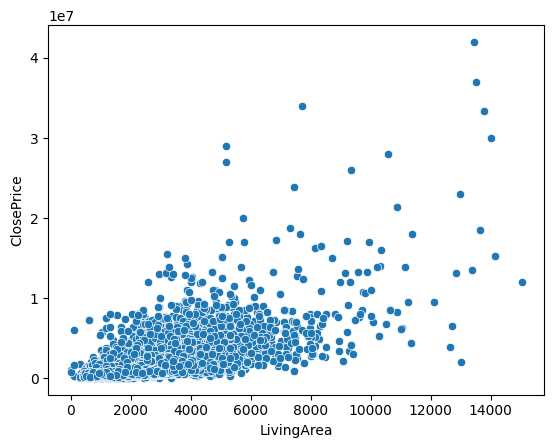

In [95]:
fdf = fdf[fdf['ClosePrice'] < 8e7]
fdf = fdf[fdf['LivingArea'] < 16000]

sns.scatterplot(x = "LivingArea", y= "ClosePrice", data = fdf)

<Axes: xlabel='LotSizeSquareFeet', ylabel='ClosePrice'>

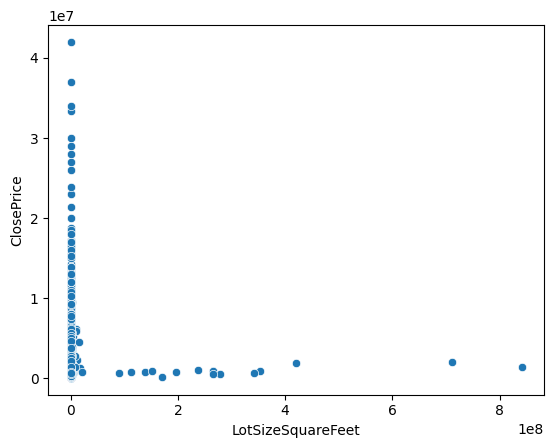

In [96]:
#LotSizeSquareFeet	YearBuilt	BathroomsTotalInteger BedroomsTotal	GarageSpaces	ClosePrice		ParkingTotal
fdf = fdf[fdf['LotSizeSquareFeet'] < 1.5e9]
sns.scatterplot(x = "LotSizeSquareFeet", y= "ClosePrice", data = fdf)

<Axes: xlabel='YearBuilt', ylabel='ClosePrice'>

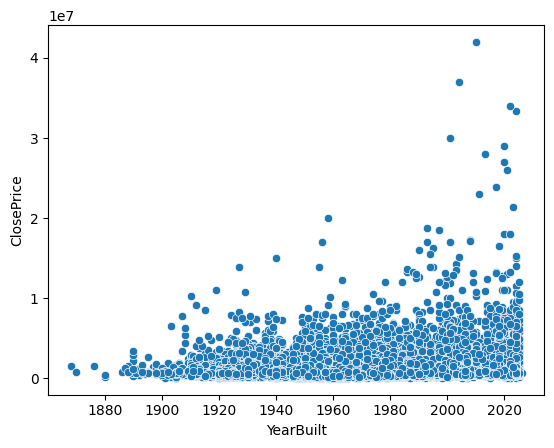

In [97]:
# #		YearBuilt	BathroomsTotalInteger BedroomsTotal	GarageSpaces	ClosePrice		ParkingTotal
fdf = fdf[fdf['YearBuilt'] > 1801]
sns.scatterplot(x = "YearBuilt", y= "ClosePrice", data = fdf)

<Axes: xlabel='BathroomsTotalInteger', ylabel='ClosePrice'>

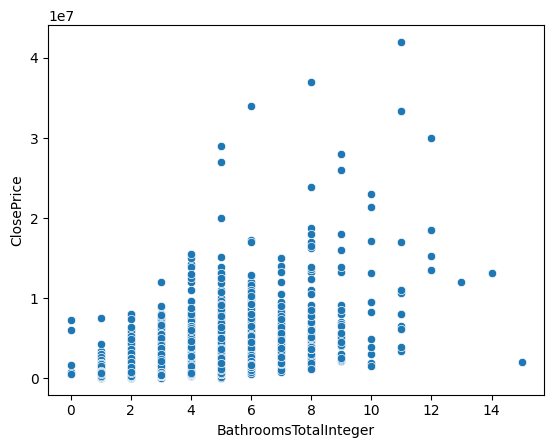

In [98]:
# #		BathroomsTotalInteger BedroomsTotal	GarageSpaces	ClosePrice		ParkingTotal
fdf = fdf[fdf['BathroomsTotalInteger'] < 20]
sns.scatterplot(x = "BathroomsTotalInteger", y= "ClosePrice", data = fdf)

<Axes: xlabel='BedroomsTotal', ylabel='ClosePrice'>

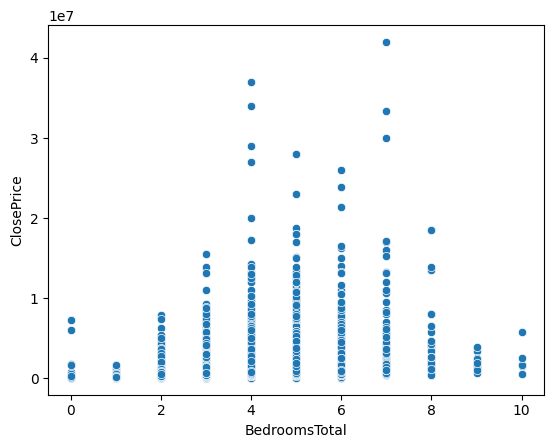

In [99]:
# #	 BedroomsTotal	GarageSpaces	ClosePrice		ParkingTotal
fdf = fdf[fdf['BedroomsTotal'] < 15]
sns.scatterplot(x = "BedroomsTotal", y= "ClosePrice", data = fdf)

<Axes: xlabel='BedroomsTotal', ylabel='ClosePrice'>

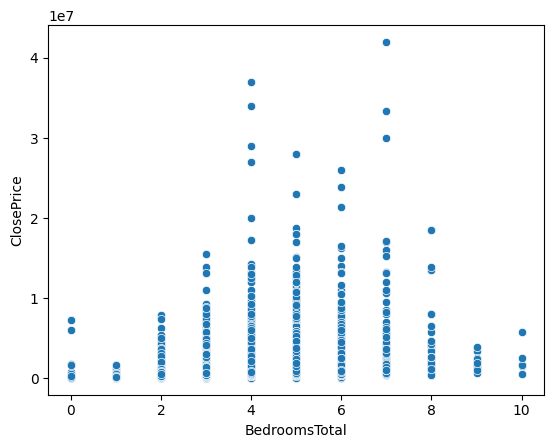

In [100]:
 #		 BedroomsTotal	GarageSpaces	ClosePrice		ParkingTotal
sns.scatterplot(x = "BedroomsTotal", y= "ClosePrice", data = fdf)

<Axes: xlabel='GarageSpaces', ylabel='ClosePrice'>

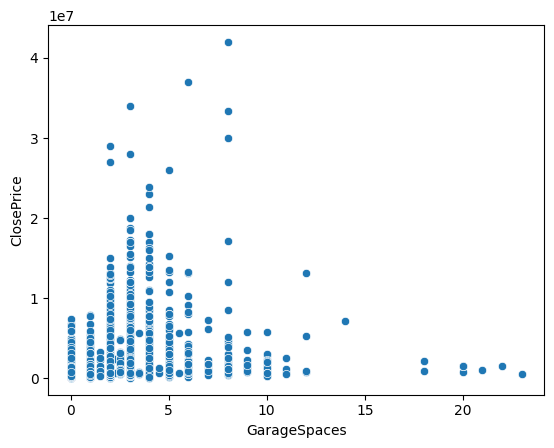

In [101]:
# #			GarageSpaces	ClosePrice		ParkingTotal
fdf = fdf[fdf['GarageSpaces'] < 150]
sns.scatterplot(x = "GarageSpaces", y= "ClosePrice", data = fdf)

<Axes: xlabel='ParkingTotal', ylabel='ClosePrice'>

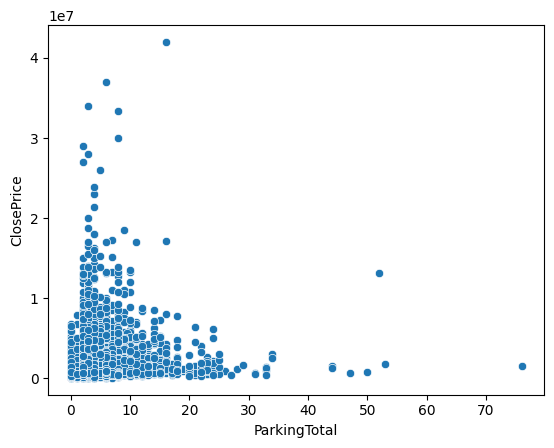

In [102]:
# #			ClosePrice		ParkingTotal
fdf = fdf[fdf['ParkingTotal'] < 100]
sns.scatterplot(x = "ParkingTotal", y= "ClosePrice", data = fdf)

<Axes: xlabel='Longitude', ylabel='ClosePrice'>

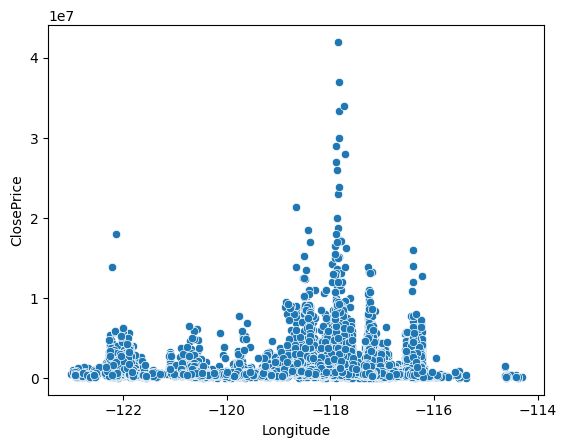

In [103]:
fdf = fdf[fdf["Longitude"] < -100]
sns.scatterplot(x = "Longitude", y= "ClosePrice", data = fdf)

<Axes: xlabel='Latitude', ylabel='ClosePrice'>

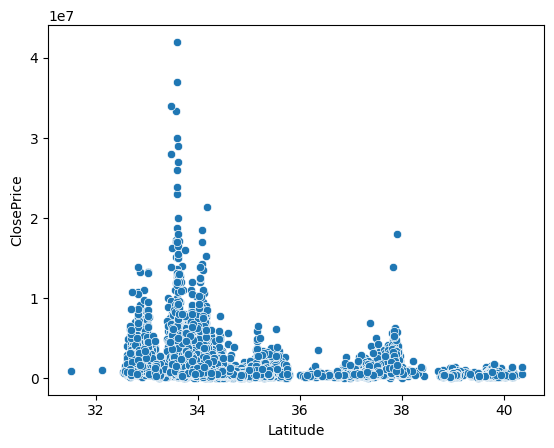

In [104]:
sns.scatterplot(x = "Latitude", y= "ClosePrice", data = fdf)

In [105]:
df_orig = fdf.copy()

Same thing that was done for the categorical variables, will be done to the numerical variables, variables that seemes to high where removed to preserve the usability of a linear regression model

In [106]:
fdf.shape[0]

42278

# Step 2 Pre-Processing Data

Above is the number of rows left after cleaning the data

In [107]:
fdf.corr(numeric_only=True)

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ClosePrice,ParkingTotal,Latitude,Longitude,PostalCode
LivingArea,1.000000,-0.003185,0.392588,0.851369,0.661515,0.476296,0.624799,0.305353,-0.054532,0.027048,0.027239
LotSizeSquareFeet,-0.003185,1.000000,0.004000,-0.001551,-0.004701,0.000453,0.001159,0.001513,-0.000895,-0.002845,-0.001873
YearBuilt,0.392588,0.004000,1.000000,0.419607,0.285169,0.368810,0.051475,0.158298,0.019322,0.135120,0.258815
BathroomsTotalInteger,0.851369,-0.001551,0.419607,1.000000,0.647285,0.404620,0.566293,0.262918,-0.081697,0.042206,0.007250
BedroomsTotal,0.661515,-0.004701,0.285169,0.647285,1.000000,0.350743,0.318350,0.201725,-0.074992,0.028974,0.005275
GarageSpaces,0.476296,0.000453,0.368810,0.404620,0.350743,1.000000,0.231403,0.469740,-0.062915,0.068098,0.048050
ClosePrice,0.624799,0.001159,0.051475,0.566293,0.318350,0.231403,1.000000,0.176095,-0.133793,-0.033250,-0.113493
ParkingTotal,0.305353,0.001513,0.158298,0.262918,0.201725,0.469740,0.176095,1.000000,-0.113298,0.116083,0.014661
Latitude,-0.054532,-0.000895,0.019322,-0.081697,-0.074992,-0.062915,-0.133793,-0.113298,1.000000,-0.848752,0.609862
Longitude,0.027048,-0.002845,0.135120,0.042206,0.028974,0.068098,-0.033250,0.116083,-0.848752,1.000000,-0.440179


As we can see above, there is multicollinearity, so we have to use LASSO, RIDGE or ELASTIC NET to help us with this issue

In [108]:
#numerical_cols = ['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomTotalInteger','BedroomsTotal','GarageSpaces','ClosePrice','ParkingTotal']
#categorical_cols = ['ViewYN', 'PoolPrivateYN', 'CountyOrParish', 'PropertySubType', 'PropertyType', 'City', 'NewConstructionYN', 'Levels', 'FireplaceYN']  

#for x1 in numerical_cols:
    #for x2 in categorical_cols:
        #sns.lmplot(x=x1, y='ClosePrice', hue=x2, data=fdf, ci=False)
        #plt.show()

ignore above 

In [109]:
from sklearn.preprocessing import StandardScaler


Scaler_training = StandardScaler()
scaled_expl_vars_test = Scaler_training.fit_transform(fdf[['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomsTotalInteger','BedroomsTotal','GarageSpaces','ClosePrice','ParkingTotal']])


fdf[['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomTotalInteger','BedroomsTotal','GarageSpaces','ClosePrice','ParkingTotal']] = scaled_expl_vars_test
fdf.head()

,ViewYN,PoolPrivateYN,LivingArea,CountyOrParish,PropertySubType,PropertyType,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,...,NewConstructionYN,Levels,ParkingTotal,FireplaceYN,City,Latitude,Longitude,StateOrProvince,PostalCode,BathroomTotalInteger
0,True,False,-0.601402,Los Angeles,SingleFamilyResidence,Residential,-0.018577,-1.425847,1.0,-0.502498,...,False,One,-0.818936,True,Burbank,34.18,-118.34,CA,91500,-1.495225
1,False,False,0.877638,San Diego,SingleFamilyResidence,Residential,-0.018754,0.836937,3.0,1.623132,...,False,Two,1.482435,True,San Diego,32.57,-117.02,CA,92100,0.373027
2,True,False,0.828268,Riverside,SingleFamilyResidence,Residential,-0.018502,1.690118,3.0,1.623132,...,True,Two,-0.358662,False,Menifee,33.73,-117.22,CA,92500,0.373027
3,True,False,0.495021,Los Angeles,SingleFamilyResidence,Residential,-0.018313,-0.275908,3.0,1.623132,...,False,Two,-0.358662,True,Los Angeles,34.20,-118.64,CA,91300,0.373027
4,False,False,0.354111,Los Angeles,SingleFamilyResidence,Residential,-0.017836,0.614368,3.0,1.623132,...,False,Two,-0.358662,True,Saugus,34.46,-118.49,CA,91300,0.373027


Z scored all numerical variables 

In [110]:
df_orig

,ViewYN,PoolPrivateYN,LivingArea,CountyOrParish,PropertySubType,PropertyType,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,...,ClosePrice,NewConstructionYN,Levels,ParkingTotal,FireplaceYN,City,Latitude,Longitude,StateOrProvince,PostalCode
0,True,False,1434.0,Los Angeles,SingleFamilyResidence,Residential,6473.0,1940.0,1.0,3.0,...,890000.0,False,One,1.0,True,Burbank,34.18,-118.34,CA,91500
1,False,False,2872.0,San Diego,SingleFamilyResidence,Residential,5219.0,2001.0,3.0,5.0,...,1138000.0,False,Two,6.0,True,San Diego,32.57,-117.02,CA,92100
2,True,False,2824.0,Riverside,SingleFamilyResidence,Residential,7000.0,2024.0,3.0,5.0,...,681877.0,True,Two,2.0,False,Menifee,33.73,-117.22,CA,92500
3,True,False,2500.0,Los Angeles,SingleFamilyResidence,Residential,8336.0,1971.0,3.0,5.0,...,900000.0,False,Two,2.0,True,Los Angeles,34.20,-118.64,CA,91300
4,False,False,2363.0,Los Angeles,SingleFamilyResidence,Residential,11705.0,1995.0,3.0,5.0,...,862000.0,False,Two,2.0,True,Saugus,34.46,-118.49,CA,91300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72466,False,False,1305.0,Riverside,SingleFamilyResidence,Residential,6969.0,1962.0,1.0,2.0,...,265000.0,False,One,0.0,False,Sun City,33.70,-117.20,CA,92500
72467,True,True,1869.0,San Bernardino,SingleFamilyResidence,Residential,217800.0,2023.0,2.0,3.0,...,1350000.0,True,One,2.0,True,Joshua Tree,34.12,-116.32,CA,92200
72468,True,False,1811.0,Madera,SingleFamilyResidence,Residential,13068.0,1987.0,2.0,4.0,...,757000.0,False,Two,0.0,True,Bass Lake,37.32,-119.55,CA,93600
72469,False,False,1014.0,Los Angeles,SingleFamilyResidence,Residential,4225.0,1926.0,1.0,2.0,...,510000.0,False,One,1.0,False,Los Angeles,33.94,-118.29,CA,90000


In [111]:
# from sklearn.preprocessing import StandardScaler


# Scaler_training = StandardScaler()
# scaled_expl_vars_test = Scaler_training.fit_transform(df_orig[['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomsTotalInteger','BedroomsTotal','GarageSpaces','ClosePrice','ParkingTotal']])


# df_orig[['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomTotalInteger','BedroomsTotal','GarageSpaces','ClosePrice','ParkingTotal']] = scaled_expl_vars_test
# df_orig.head()

ignore above

In [112]:
categorical_df = fdf[['ViewYN', 'PoolPrivateYN', 'CountyOrParish', 'PropertySubType', 'PropertyType', 'NewConstructionYN', 'Levels', 'FireplaceYN','City','StateOrProvince']]
categorical_df
indicator_df = pd.get_dummies(categorical_df, drop_first=True, dtype=int)
indicator_df
fdf = fdf.drop(columns=categorical_df.columns)
fdf = pd.concat([fdf, indicator_df], axis=1)
fdf

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ClosePrice,ParkingTotal,Latitude,Longitude,...,City_Wofford Heights,City_Woodcrest,City_Woodlake,City_Woodland Hills,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yucaipa,City_Yucca Valley
0,-0.601402,-0.018577,-1.425847,1.0,-0.502498,-1.097844,-0.184768,-0.818936,34.18,-118.34,...,0,0,0,0,0,0,0,0,0,0
1,0.877638,-0.018754,0.836937,3.0,1.623132,1.076271,0.030680,1.482435,32.57,-117.02,...,0,0,0,0,0,0,0,0,0,0
2,0.828268,-0.018502,1.690118,3.0,1.623132,-0.010786,-0.365572,-0.358662,33.73,-117.22,...,0,0,0,0,0,0,0,0,0,0
3,0.495021,-0.018313,-0.275908,3.0,1.623132,-0.010786,-0.176080,-0.358662,34.20,-118.64,...,0,0,0,0,0,0,0,0,0,0
4,0.354111,-0.017836,0.614368,3.0,1.623132,-0.010786,-0.209092,-0.358662,34.46,-118.49,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72466,-0.734083,-0.018507,-0.609761,1.0,-1.565313,-2.184901,-0.727729,-1.279210,33.70,-117.20,...,0,0,0,0,0,0,0,0,0,0
72467,-0.153987,0.011344,1.653023,2.0,-0.502498,-0.010786,0.214852,-0.358662,34.12,-116.32,...,0,0,0,0,0,0,0,0,0,0
72468,-0.213643,-0.017643,0.317609,2.0,0.560317,-2.184901,-0.300310,-1.279210,37.32,-119.55,...,0,0,0,0,0,0,0,0,0,0
72469,-1.033388,-0.018895,-1.945175,1.0,-1.565313,-1.097844,-0.514888,-0.818936,33.94,-118.29,...,0,0,0,0,0,0,0,0,0,0


We will need to use pd.getDummies for categorical variables, as thats the only way Risge, Lasso, Elastic Net, Random Forest and XGBoost work

In [113]:
categorical_df1 = df_orig[['ViewYN', 'PoolPrivateYN', 'CountyOrParish', 'PropertySubType', 'PropertyType', 'NewConstructionYN', 'Levels', 'FireplaceYN','City','StateOrProvince']]
categorical_df1
indicator_df1 = pd.get_dummies(categorical_df1, drop_first=True, dtype=int)
indicator_df1
df_orig = df_orig.drop(columns=categorical_df1.columns)
df_orig = pd.concat([df_orig, indicator_df1], axis=1)
df_orig

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ClosePrice,ParkingTotal,Latitude,Longitude,...,City_Wofford Heights,City_Woodcrest,City_Woodlake,City_Woodland Hills,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yucaipa,City_Yucca Valley
0,1434.0,6473.0,1940.0,1.0,3.0,1.0,890000.0,1.0,34.18,-118.34,...,0,0,0,0,0,0,0,0,0,0
1,2872.0,5219.0,2001.0,3.0,5.0,3.0,1138000.0,6.0,32.57,-117.02,...,0,0,0,0,0,0,0,0,0,0
2,2824.0,7000.0,2024.0,3.0,5.0,2.0,681877.0,2.0,33.73,-117.22,...,0,0,0,0,0,0,0,0,0,0
3,2500.0,8336.0,1971.0,3.0,5.0,2.0,900000.0,2.0,34.20,-118.64,...,0,0,0,0,0,0,0,0,0,0
4,2363.0,11705.0,1995.0,3.0,5.0,2.0,862000.0,2.0,34.46,-118.49,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72466,1305.0,6969.0,1962.0,1.0,2.0,0.0,265000.0,0.0,33.70,-117.20,...,0,0,0,0,0,0,0,0,0,0
72467,1869.0,217800.0,2023.0,2.0,3.0,2.0,1350000.0,2.0,34.12,-116.32,...,0,0,0,0,0,0,0,0,0,0
72468,1811.0,13068.0,1987.0,2.0,4.0,0.0,757000.0,0.0,37.32,-119.55,...,0,0,0,0,0,0,0,0,0,0
72469,1014.0,4225.0,1926.0,1.0,2.0,1.0,510000.0,1.0,33.94,-118.29,...,0,0,0,0,0,0,0,0,0,0


Pd.getDummies done for this dataset as well

# Step 3 Machine Learning

## Starting Linear Regression Ridge

In [114]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(fdf, test_size = 0.20, random_state = 207)

Splitting data into train test split

In [115]:
feature_train = df_train.drop(['ClosePrice'], axis=1)
feature_train.head()

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ParkingTotal,Latitude,Longitude,PostalCode,...,City_Wofford Heights,City_Woodcrest,City_Woodlake,City_Woodland Hills,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yucaipa,City_Yucca Valley
45536,-0.418322,-0.018445,0.206325,3.0,-0.502498,-0.010786,-0.358662,33.92,-117.24,92500,...,0,0,0,0,0,0,0,0,0,0
24744,-1.335779,-0.018903,-1.203279,2.0,-2.628128,-2.184901,-1.279210,34.08,-118.09,91700,...,0,0,0,0,0,0,0,0,0,0
1252,-0.309297,-0.018474,-0.832330,2.0,0.560317,-0.010786,-0.358662,33.79,-117.95,92800,...,0,0,0,0,0,0,0,0,0,0
20090,-0.122103,-0.018465,-0.980710,3.0,1.623132,-0.010786,-0.358662,33.74,-117.92,92700,...,0,0,0,0,0,0,0,0,0,0
58131,1.852693,-0.016780,1.504643,4.0,-0.502498,1.076271,0.101612,33.62,-116.27,92200,...,0,0,0,0,0,0,0,0,0,0


In [116]:
feature_test = df_test.drop(['ClosePrice'], axis=1)
feature_test.head()

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ParkingTotal,Latitude,Longitude,PostalCode,...,City_Wofford Heights,City_Woodcrest,City_Woodlake,City_Woodland Hills,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yucaipa,City_Yucca Valley
10946,1.017519,-0.018786,1.690118,3.0,1.623132,-0.010786,-0.358662,33.61,-117.11,92500,...,0,0,0,0,0,0,0,0,0,0
56664,-0.255813,-0.018544,-1.833890,3.0,0.560317,-0.010786,-0.358662,33.97,-118.32,90000,...,0,0,0,0,0,0,0,0,0,0
17263,-0.460492,-0.018568,0.169230,2.0,1.623132,-0.010786,-0.358662,33.91,-117.45,92500,...,0,0,0,0,0,0,0,0,0,0
52366,0.642102,-0.018445,1.022411,3.0,0.560317,1.076271,0.101612,33.71,-117.31,92500,...,0,0,0,0,0,0,0,0,0,0
24559,-1.011789,-0.018669,-1.129089,2.0,-0.502498,-2.184901,-1.279210,33.90,-118.09,90600,...,0,0,0,0,0,0,0,0,0,0


In [117]:
target_train = df_train["ClosePrice"]
target_train


45536   -0.536606
24744   -0.419327
1252    -0.071832
20090   -0.123956
58131    1.952328
           ...   
13573   -0.254267
68930    0.030680
67696   -0.050113
21406   -0.560062
35635    0.084541
Name: ClosePrice, Length: 33822, dtype: float64

In [118]:
target_test = df_test["ClosePrice"]
target_test

10946   -0.283330
56664   -0.024051
17263   -0.367202
52366   -0.414983
24559   -0.306391
           ...   
30348   -0.553981
7522    -0.228204
36995   -0.289111
25718   -0.306391
71017   -0.110925
Name: ClosePrice, Length: 8456, dtype: float64

Split the data into training features matrix, traing target array, and test features matrix and test target array

In [119]:
# import statsmodels.api as sm
# import matplotlib.pyplot as plt
# X_with_const = sm.add_constant(feature_test)
# target_test = np.log1p(target_test)
# model = sm.OLS(target_test, X_with_const).fit()

# plt.scatter(model.fittedvalues, model.resid)
# plt.axhline(y=0, color='r', linestyle='--')  
# plt.xlabel('Fitted values') 
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.show()

ignore above

In [120]:
from sklearn.linear_model import LinearRegression

lin_reg_mod = LinearRegression()

0.49373847613631794


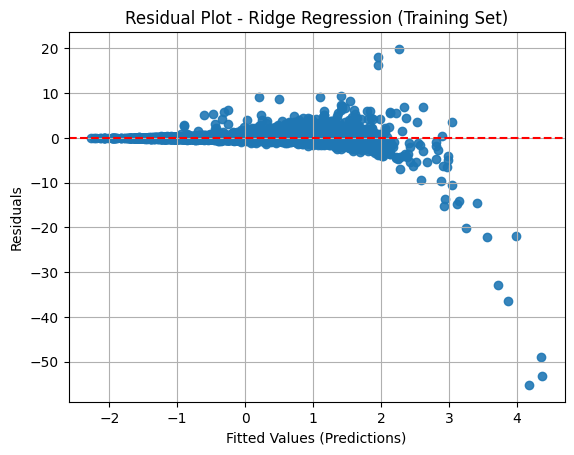

In [121]:
target_train_log = np.log1p(target_train)

ridge = Ridge(alpha=0.895, max_iter = 1000)
ridge.fit(feature_train, target_train_log)

preds_log = ridge.predict(feature_train)
preds_log1 = ridge.score(feature_train, target_train)
print(preds_log1)
preds_real = np.expm1(preds_log) 

residuals = target_train - preds_real

plt.scatter(preds_log, residuals, alpha=0.895)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.title('Residual Plot - Ridge Regression (Training Set)')
plt.grid(True)
plt.show()

Here I am checking if the data is fit for a linear regression model, as we can see the residual plot clearly does not fit, as a result, we may need to use other models outside of linear regression

In [122]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso
data = []
for i in np.arange(0,0.9,0.005):
    lin_reg_mod = Ridge(alpha=i, max_iter=1000)
    lin_reg_mod.fit(feature_train, target_train)
    x = lin_reg_mod.score(feature_test, target_test)
    data.append([i, x])
df_rsqrR = pd.DataFrame(data, columns=['lambda', 'test_r2'])
df_rsqrR


,lambda,test_r2
0,0.000,-7.952950e+24
1,0.005,7.125411e-01
2,0.010,7.126988e-01
3,0.015,7.127765e-01
4,0.020,7.128197e-01
...,...,...
175,0.875,7.132887e-01
176,0.880,7.132897e-01
177,0.885,7.132906e-01
178,0.890,7.132915e-01


Started off by hyperparameter tuning lambda values for ridge

In [123]:
df_rsqrR.nlargest(1,"test_r2")

,lambda,test_r2
179,0.895,0.713292


Above is the highest r2 for ridge with the best lambda value, at 0.71

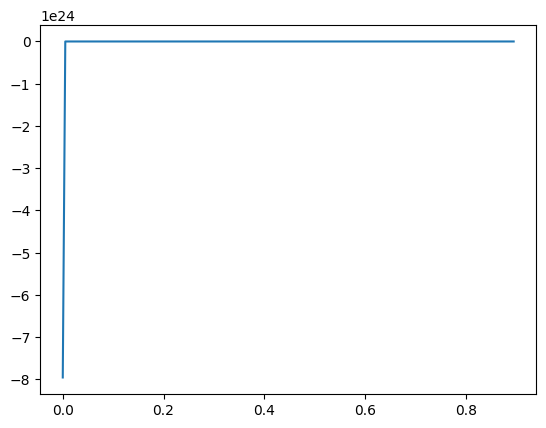

In [124]:
plt.plot(df_rsqrR['lambda'].values, df_rsqrR['test_r2'].values)

Above is a visual representation of the performance of different lambda values

## Starting Linear Reegression Lasso

In [125]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso
data = []
for i in np.arange(0,0.9,0.005):
    lin_reg_mod = Lasso(alpha=i, max_iter=1000)
    lin_reg_mod.fit(feature_train, target_train)
    x = lin_reg_mod.score(feature_test, target_test)
    data.append([i, x])
df_rsqrL = pd.DataFrame(data, columns=['lambda', 'test_r2'])
df_rsqrL


C:\Users\sunsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\sunsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sunsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider i

,lambda,test_r2
0,0.000,0.712198
1,0.005,0.577921
2,0.010,0.557824
3,0.015,0.548070
4,0.020,0.540989
...,...,...
175,0.875,0.004994
176,0.880,0.004995
177,0.885,0.004995
178,0.890,0.004996


Same thing that was done for ridge, is now being done with Lasso

In [126]:
df_rsqrL.nlargest(1,'test_r2')

,lambda,test_r2
0,0.0,0.712198


Lambda of 0 gets us the highest test r2 of 0.71

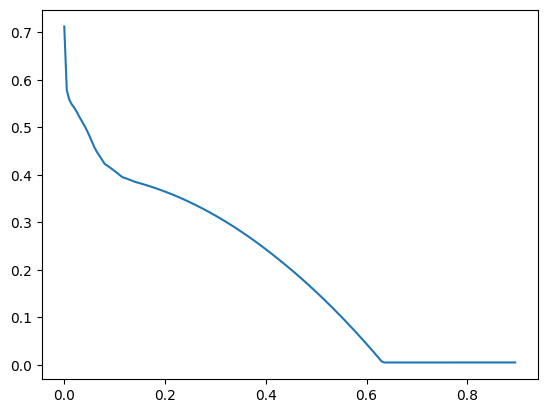

In [127]:
plt.plot(df_rsqrL['lambda'].values, df_rsqrL['test_r2'].values)

Above is a visual representation of the ridge hyperparameter tuning performance

## Starting Linear Reegression ELastic Net

In [128]:
data = []
for alpha_val in np.arange(0.001, 0.9, 0.005):
    model = ElasticNet(alpha=alpha_val, l1_ratio=0.2, max_iter=10000)
    model.fit(feature_train, target_train)
    test_r2 = model.score(feature_test, target_test)
    data.append([alpha_val, test_r2])

# Convert to DataFrame
df_rsqrE = pd.DataFrame(data, columns=['alpha', 'test_r2'])
df_rsqrE

,alpha,test_r2
0,0.001,0.682679
1,0.006,0.606793
2,0.011,0.582649
3,0.016,0.570936
4,0.021,0.563683
...,...,...
175,0.876,0.314655
176,0.881,0.313993
177,0.886,0.313330
178,0.891,0.312666


Same thing as Ridge and Lasso now being doen for elastic net

In [129]:
df_rsqrE.nlargest(1,"test_r2")

,alpha,test_r2
0,0.001,0.682679


Highest lambda of 0.001 gave us the highest r2 at 0.68

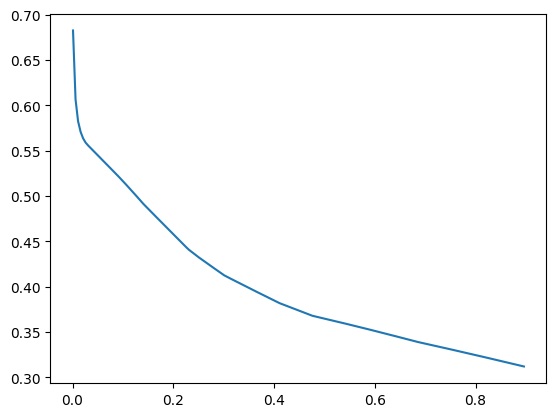

In [130]:
plt.plot(df_rsqrE['alpha'].values, df_rsqrE['test_r2'].values)

Above is a visual representation of the elastic net performance

### Starting K fold cross validation on Linear Reegression Ridge

In [131]:
from sklearn.model_selection import KFold
crossval = KFold(n_splits=5, shuffle=True, random_state=437)
crossval

data = []
for i in np.arange(0,0.51,0.01):
    ridge1 = Ridge(alpha=i, max_iter=1000)
    test_fold_r2 = cross_val_score(ridge1, feature_train, target_train, cv=crossval, scoring="r2")
    data.append([i, test_fold_r2, test_fold_r2.mean()])
df_ptune = pd.DataFrame(data, columns=['lambda', 'rsqrs', 'mean_rsqr'])
df_ptune


,lambda,rsqrs,mean_rsqr
0,0.00,"[-2.0396269002650288e+25, -2.078382976835399e+...",-1.102444e+25
1,0.01,"[0.6730280860766804, 0.7409962847214677, 0.720...",7.103076e-01
2,0.02,"[0.6736148944947542, 0.7407650744406322, 0.722...",7.110347e-01
3,0.03,"[0.6738846926652362, 0.7406164240230437, 0.724...",7.114251e-01
4,0.04,"[0.674031219702527, 0.7405403141240471, 0.7250...",7.116068e-01
5,0.05,"[0.6741177017276436, 0.7405087132565276, 0.725...",7.116597e-01
6,0.06,"[0.674170955066652, 0.7405035298396196, 0.7248...",7.116355e-01
7,0.07,"[0.6742042896816197, 0.7405139900078024, 0.724...",7.115667e-01
8,0.08,"[0.6742250323452512, 0.7405336485364831, 0.723...",7.114736e-01
9,0.09,"[0.6742375205284533, 0.7405585842737057, 0.723...",7.113689e-01


Since Ridge was the best perorming model, I decided to impliment K-fold cross validation on it, just to make sure the test r2 is accurate, which it is

In [132]:
df_ptune.nlargest(1,'mean_rsqr')

,lambda,rsqrs,mean_rsqr
5,0.05,"[0.6741177017276436, 0.7405087132565276, 0.725...",0.71166


### Starting Random Forest Regression

In [133]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
df_train_rf, df_test_rf = train_test_split(df_orig, test_size = 0.20, random_state = 207)


simply importing the model

In [134]:
feature_train_rf = df_train_rf.drop(['ClosePrice'], axis=1)
feature_train_rf.head()

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ParkingTotal,Latitude,Longitude,PostalCode,...,City_Wofford Heights,City_Woodcrest,City_Woodlake,City_Woodland Hills,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yucaipa,City_Yucca Valley
45536,1612.0,7405.0,1984.0,3.0,3.0,2.0,2.0,33.92,-117.24,92500,...,0,0,0,0,0,0,0,0,0,0
24744,720.0,4171.0,1946.0,2.0,1.0,0.0,0.0,34.08,-118.09,91700,...,0,0,0,0,0,0,0,0,0,0
1252,1718.0,7200.0,1956.0,2.0,4.0,2.0,2.0,33.79,-117.95,92800,...,0,0,0,0,0,0,0,0,0,0
20090,1900.0,7260.0,1952.0,3.0,5.0,2.0,2.0,33.74,-117.92,92700,...,0,0,0,0,0,0,0,0,0,0
58131,3820.0,19166.0,2019.0,4.0,3.0,3.0,3.0,33.62,-116.27,92200,...,0,0,0,0,0,0,0,0,0,0


In [135]:
feature_test_rf = df_test_rf.drop(['ClosePrice'], axis=1)
feature_test_rf.head()

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ParkingTotal,Latitude,Longitude,PostalCode,...,City_Wofford Heights,City_Woodcrest,City_Woodlake,City_Woodland Hills,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yucaipa,City_Yucca Valley
10946,3008.0,4996.0,2024.0,3.0,5.0,2.0,2.0,33.61,-117.11,92500,...,0,0,0,0,0,0,0,0,0,0
56664,1770.0,6702.0,1929.0,3.0,4.0,2.0,2.0,33.97,-118.32,90000,...,0,0,0,0,0,0,0,0,0,0
17263,1571.0,6534.0,1983.0,2.0,5.0,2.0,2.0,33.91,-117.45,92500,...,0,0,0,0,0,0,0,0,0,0
52366,2643.0,7405.0,2006.0,3.0,4.0,3.0,3.0,33.71,-117.31,92500,...,0,0,0,0,0,0,0,0,0,0
24559,1035.0,5825.0,1948.0,2.0,3.0,0.0,0.0,33.90,-118.09,90600,...,0,0,0,0,0,0,0,0,0,0


In [136]:
target_train_rf = np.log1p(df_train_rf["ClosePrice"])
target_train_rf


45536    13.091906
24744    13.337476
1252     13.835314
20090    13.774690
58131    15.024471
           ...    
13573    13.604791
68930    13.944784
67696    13.859528
21406    13.034627
35635    13.997833
Name: ClosePrice, Length: 33822, dtype: float64

In [137]:
target_test_rf = np.log1p(df_test_rf["ClosePrice"])
target_test_rf

10946    13.562611
56664    13.887832
17263    13.429850
52366    13.345509
24559    13.527830
           ...    
30348    13.049795
7522     13.641158
36995    13.554006
25718    13.527830
71017    13.790194
Name: ClosePrice, Length: 8456, dtype: float64

ABove I am Splitting df_orig (which is the dataframe that has not been Z score standradized) into test and target features matrixes and targets array's

In [138]:
# # # data = []
# # # for i in np.arange(50,201,50):
    
# # #     data.append([i,r2])
# # # df_rfr = pd.DataFrame(data, columns=['n_estimators','r2'])
# # # df_rfr

rf = RandomForestRegressor(
        n_estimators=200,    
        max_depth=None,      
        max_features= 1.0,
        random_state=42
    )   
rf.fit(feature_train_rf, target_train_rf)
r2 = rf.score(feature_test_rf,target_test_rf)
r2

# # # # 'n_estimators': [50, 100, 200],               # Number of trees
# # # #     'max_depth': [None, 10, 20, 30],              # Max depth of each tree
# # # #     'min_samples_split': [2, 5, 10],              # Min samples to split a node
# # # #     'min_samples_leaf': [1, 2, 4],                 # Min samples at a leaf node
# # # #     'max_features': ['auto', 'sqrt', 'log2'],     # Number of features to consider at split
# # # #     'bootstrap': [True, False],                    # Use bootstrap samples or not
# # # #     'criterion': ['mse', 'mae']     

0.9070754251705118

Above I am implementing a Random Forest Regressor, with no hyperparameter tuning, simply using an out of the box model

In [139]:

rf = RandomForestRegressor(
    n_estimators=200,    
    max_depth=15,      
    max_features= 1.0,
    random_state=42
)   
rf.fit(feature_train_rf, target_train_rf)
r2 = rf.score(feature_test_rf,target_test_rf)
r2

0.8959484448205641

Above I am messing with the max_depth at 15

In [140]:
rf = RandomForestRegressor(
        n_estimators=200,    
        max_depth=None,      
        max_features= 1.0,
        random_state=42
    )   
rf.fit(feature_train_rf, target_train_rf)
r2 = rf.score(feature_test_rf,target_test_rf)
r2

0.9070754251705118

Above I am messing with the MAx depth being "none"

In [141]:
rf = RandomForestRegressor(
        n_estimators=200,    
        max_depth=None,      
        max_features= 'sqrt',
        random_state=42
    )   
rf.fit(feature_train_rf, target_train_rf)
r2 = rf.score(feature_test_rf,target_test_rf)
r2

0.8971599113058616

Above I am messing with the max_features per tree, using sqrt for this one

In [142]:
rf = RandomForestRegressor(
        n_estimators=200,    
        max_depth=None,      
        max_features= 'log2',
        random_state=42
    )   
rf.fit(feature_train_rf, target_train_rf)
r2 = rf.score(feature_test_rf,target_test_rf)
r2

0.8957078835203997

Above I am messing with the max_features per tree, using log2 for this one

### Starting XGBoost regression

In [143]:
data = []
for i in np.arange(100,600,100):
    model = XGBRegressor(n_estimators=i, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(feature_train_rf, target_train_rf)
    r2 = model.score(feature_test_rf,target_test_rf)
    data.append([i,r2])
df_nest_xgb = pd.DataFrame(data, columns = ['n_estimator value', 'test_r2'])
df_nest_xgb

df_nest_xgb.nlargest(1,'test_r2')

,n_estimator value,test_r2
4,500,0.913406


Using XGBoost, and tweaking the n_estimators, from 100 to 600 by factors of 100

In [144]:
data = []
for i in np.arange(0.1,0.6,0.1):
    model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(feature_train_rf, target_train_rf)
    r2 = model.score(feature_test_rf,target_test_rf)
    data.append([i,r2])
df_nest_xgb = pd.DataFrame(data, columns = ['learning_rate', 'test_r2'])
df_nest_xgb

df_nest_xgb.nlargest(1,'test_r2')

,learning_rate,test_r2
0,0.1,0.913406


Using XGBoost and tweaking the learning rate from 0.1 to 0.6 going up by 0.1, previously n_estimators of 500, gave us the highest r^2 value

In [147]:
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt


data = []
for i in np.arange(3,10,1):
    model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=i, random_state=42)
    model.fit(feature_train_rf, target_train_rf)
    r2 = model.score(feature_test_rf,target_test_rf)
    data.append([i,r2])
df_nest_xgb = pd.DataFrame(data, columns = ['max_depth', 'test_r2'])
df_nest_xgb

df_nest_xgb.nlargest(1,'test_r2')



,max_depth,test_r2
5,8,0.917933


Lastly we are messing with the max_depth, going from 3 to 10, going up by 1. This produced the model with the HIGHEST r^2 at 0.91